In [1]:
import sys
sys.path.append('../..')

In [2]:
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict

from Bio import PDB
import Bio
import Bio.PDB

In [3]:
from DomainPrediction.protein.base import BaseProtein
from DomainPrediction.protein.base import FoldedProtein
from DomainPrediction.utils import helper
from DomainPrediction.eval import metrics
from DomainPrediction.utils.hmmtools import HmmerTools
from DomainPrediction.utils.tmalign import TMalign
from DomainPrediction.utils.constants import *

In [4]:
root = '../../..'
data_path = '/data/users/kgeorge/workspace/Data'
pmpnn_path = os.path.join(data_path, 'pmpnn_experiments/gxps_exp')
esm3_path = os.path.join(data_path, 'esm3_experiments/gxps_exp')
evodiff_path = os.path.join(data_path, 'evodiff_experiments/gxps_exp')
esm2_entropy_path = os.path.join(data_path, 'esm2_experiments/entropy/gxps_exp')

In [5]:
protein_6mfw = BaseProtein(file=os.path.join(data_path, 'gxps/gxps_ATC_hm_6mfy.pdb'))

#### Extract T domains and save

In [6]:
def extract_residues(pdb_file, chain_id, start_residue, end_residue, output_file):
    """
        This was from chatgpt - it works!
        I was lazy to create my own
    """
    # Create a parser and structure object
    parser = PDB.PDBParser()
    structure = parser.get_structure('protein', pdb_file)
    
    # Create a PDBIO object to write the output
    io = PDB.PDBIO()
    
    class ResidueSelector(PDB.Select):
        def accept_residue(self, residue):
            # Check if the residue is within the specified range
            return start_residue <= residue.id[1] <= end_residue
    
    # Select the chain and extract the residues
    chain = structure[0][chain_id]
    
    # Set the structure to be written (the selected residues)
    io.set_structure(chain)
    
    # Save the selected residues to a new PDB file
    io.save(output_file, ResidueSelector())

In [7]:
# chain_id = "A"
# start_residue = T_gxps_atc[0] + 1
# end_residue = T_gxps_atc[-1] + 1 

# paths = [pmpnn_path, esm3_path, evodiff_path, esm2_entropy_path]
# for _path in paths:
#     print(_path)
#     pdb_path = os.path.join(_path, 'gxps_pdbs')
#     for f in os.listdir(pdb_path):
#         file = os.path.join(pdb_path, f)
#         if f.endswith('.pdb'):
#             input_file = os.path.join(pdb_path, f)
#             output_file = os.path.join(pdb_path, f.replace('.pdb', '.T.pdb'))

#             extract_residues(input_file, chain_id, start_residue, end_residue, output_file)

#### Get TM Score against full proteins and T domains

We can skip random as they have poor sequences

In [9]:
paths = [pmpnn_path, esm3_path, evodiff_path, esm2_entropy_path]
for _path in paths:
    print(_path)
    pdbs_path = os.path.join(_path, 'gxps_pdbs')
    
    ## Sanity check
    print('Checking keys in metadata')
    for f in tqdm(os.listdir(pdbs_path)):
        if f.endswith('.meta.npz'):
            meta_file = os.path.join(pdbs_path, f)
            metadata = dict(np.load(meta_file))
            for key in ['predicted_aligned_error', 'ptm', 'esm2_650M_perplexity', 'max_TM_score', 'T_TM_score']:
                assert key in metadata

/data/users/kgeorge/workspace/Data/pmpnn_experiments/gxps_exp
Checking keys in metadata


100%|██████████| 3000/3000 [04:13<00:00, 11.82it/s]


/data/users/kgeorge/workspace/Data/esm3_experiments/gxps_exp
Checking keys in metadata


100%|██████████| 3000/3000 [04:05<00:00, 12.22it/s]


/data/users/kgeorge/workspace/Data/evodiff_experiments/gxps_exp
Checking keys in metadata


100%|██████████| 3000/3000 [04:06<00:00, 12.16it/s]


/data/users/kgeorge/workspace/Data/esm2_experiments/entropy/gxps_exp
Checking keys in metadata


100%|██████████| 2982/2982 [04:05<00:00, 12.15it/s]


#### TM-score/pLDDT vs perplexity

In [ ]:
# ## This is taking up too much memory

# paths_dict = {
#     'pmpnn': pmpnn_path, 
#     'esm3': esm3_path, 
#     'evodiff': evodiff_path, 
#     'esm2': esm2_entropy_path
# }

# proteins = defaultdict(list)

# for _model, _path in paths_dict.items():
#     print(_path)
#     pdbs_path = os.path.join(_path, 'gxps_pdbs')
#     for f in tqdm(os.listdir(pdbs_path)):
#         if f.endswith('.pdb') and not f.endswith('T.pdb'):
#             file = os.path.join(pdbs_path, f)
#             proteins[_model].append(FoldedProtein(file, id=f.replace('.pdb', '')))

In [13]:
## This is taking up too much memory
paths_dict = {
    'pmpnn': pmpnn_path, 
    'esm3': esm3_path, 
    'evodiff': evodiff_path, 
    'esm2': esm2_entropy_path
}

proteins = defaultdict(list)

def get_plddt(file):
    pdbparser = Bio.PDB.PDBParser(QUIET=True)
    struct = pdbparser.get_structure('protein', file)
    plddts = np.array([a.get_bfactor() for a in struct.get_atoms()])
    plddt = plddts.mean()

    return plddt

for _model, _path in paths_dict.items():
    print(_path)
    pdbs_path = os.path.join(_path, 'gxps_pdbs')
    for f in tqdm(os.listdir(pdbs_path)):
        if f.endswith('.pdb') and not f.endswith('T.pdb'):
            file = os.path.join(pdbs_path, f)

            plddt = get_plddt(file)
            assert os.path.isfile(file.replace('.pdb', '.T.pdb'))
            plddt_T = get_plddt(file.replace('.pdb', '.T.pdb'))
            
            meta_file = file.replace('.pdb', '.meta.npz')
            assert os.path.isfile(meta_file)

            metadata = dict(np.load(meta_file))
            metadata['predicted_aligned_error'] = 0     # reduce memory. pAE (1000x1000) np array
            metadata['plddt'] = plddt
            metadata['plddt_T'] = plddt_T
            
            proteins[_model].append(metadata)

/data/users/kgeorge/workspace/Data/pmpnn_experiments/gxps_exp


100%|██████████| 3000/3000 [04:26<00:00, 11.27it/s]


/data/users/kgeorge/workspace/Data/esm3_experiments/gxps_exp


100%|██████████| 3000/3000 [09:59<00:00,  5.00it/s]


/data/users/kgeorge/workspace/Data/evodiff_experiments/gxps_exp


100%|██████████| 3000/3000 [09:47<00:00,  5.11it/s]


/data/users/kgeorge/workspace/Data/esm2_experiments/entropy/gxps_exp


100%|██████████| 2982/2982 [09:34<00:00,  5.19it/s]


In [14]:
proteins['pmpnn'][0]

{'predicted_aligned_error': 0,
 'ptm': array(0.55596787, dtype=float32),
 'esm2_650M_perplexity': array(4.92718154),
 'max_TM_score': array(0.63987),
 'T_TM_score': array(0.93997),
 'plddt': 0.8664754612777709,
 'plddt_T': 0.8273529411764706}

In [15]:
proteins.keys()

dict_keys(['pmpnn', 'esm3', 'evodiff', 'esm2'])

In [16]:
for key in proteins:
    if key == 'esm2':
        assert len(proteins[key]) == 994
    else:
        assert len(proteins[key]) == 1000

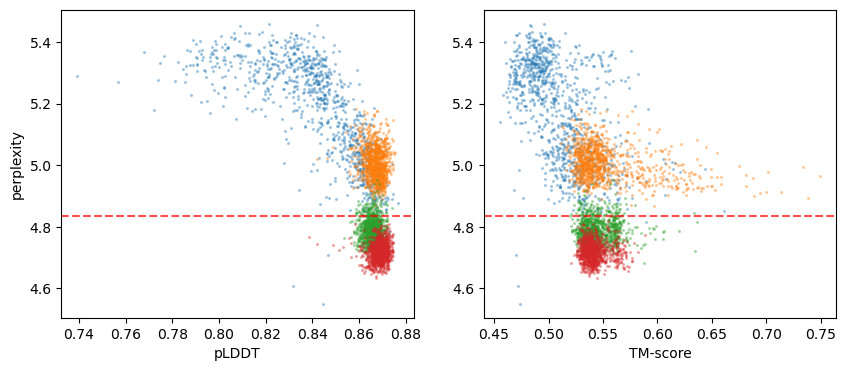

In [17]:
## pLDDT and pTM scores vs TM score
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
labels = ['ESM2 entropy', 'PMPNN', 'EvoDiff', 'ESM3']
keys = ['esm2', 'pmpnn', 'evodiff', 'esm3']

wt_perplexity = 4.835815952586172
_ = ax[0].axhline(wt_perplexity, linestyle='--', color='red', label='wt', alpha=0.7)
_ = ax[1].axhline(wt_perplexity, linestyle='--', color='red', label='wt', alpha=0.7)

for label, key in zip(labels, keys):
    _ = ax[0].scatter([p['plddt'] for p in proteins[key]], [p['esm2_650M_perplexity'] for p in proteins[key]], 
                      marker='.', label=label, alpha=0.3, s=7)
    _ = ax[1].scatter([p['max_TM_score'] for p in proteins[key]], [p['esm2_650M_perplexity'] for p in proteins[key]], 
                      marker='.', label=label, alpha=0.3, s=7)
    
_ = ax[0].set_xlabel('pLDDT')
_ = ax[0].set_ylabel('perplexity')

_ = ax[1].set_xlabel('TM-score')

# _ = ax.legend()

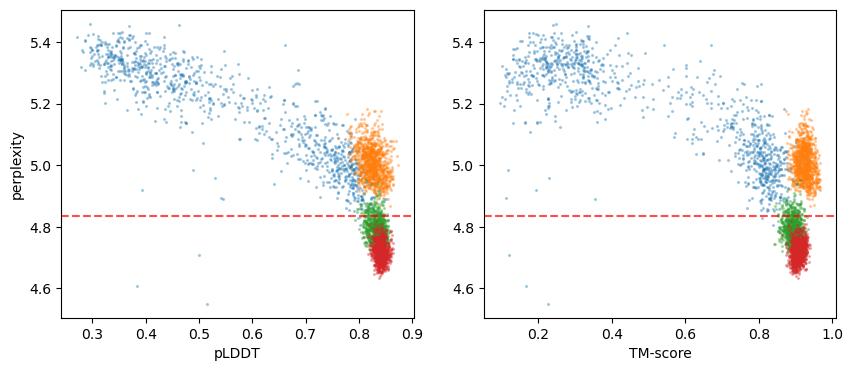

In [18]:
## pLDDT and pTM scores vs TM score
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
labels = ['ESM2 entropy', 'PMPNN', 'EvoDiff', 'ESM3']
keys = ['esm2', 'pmpnn', 'evodiff', 'esm3']

wt_perplexity = 4.835815952586172
_ = ax[0].axhline(wt_perplexity, linestyle='--', color='red', label='wt', alpha=0.7)
_ = ax[1].axhline(wt_perplexity, linestyle='--', color='red', label='wt', alpha=0.7)

for label, key in zip(labels, keys):
    _ = ax[0].scatter([p['plddt_T'] for p in proteins[key]], [p['esm2_650M_perplexity'] for p in proteins[key]], 
                      marker='.', label=label, alpha=0.3, s=7)
    _ = ax[1].scatter([p['T_TM_score'] for p in proteins[key]], [p['esm2_650M_perplexity'] for p in proteins[key]], 
                      marker='.', label=label, alpha=0.3, s=7)
    
_ = ax[0].set_xlabel('pLDDT')
_ = ax[0].set_ylabel('perplexity')

_ = ax[1].set_xlabel('TM-score')

# _ = ax.legend()